# References

- The competition is https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition (it ended long time ago)
- Pytorch official docs:
    - [Finetuning Torchvision Models](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
    - [Writing Custom Datasets, DataLoaders and Transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
    - Any other docs refered to train model or whatever, left comments on each section.
- Refered kernels:
    - [Dog_vs_Cat Transfer Learning - VGG16 by Pytorch](https://www.kaggle.com/bootiu/dog-vs-cat-transfer-learning-vgg16-by-pytorch)

# Import libraries

In [1]:
# Standard library
import copy
import glob
import multiprocessing
import os
import time
import zipfile

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Related third party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io, transform
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Pre process for each environment

### For Kaggle kernel

In [2]:
base_dir = '../input/dogs-vs-cats-redux-kernels-edition'
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')

train_dir = '../data/train'
test_dir = '../data/test'

### For Google Colab

It assumes that downloaded data will be located under `'My Drive/Data Set/'`

In [3]:
# with zipfile.ZipFile('./drive/My Drive/Data Set/dogs-vs-cats-redux-kernels-edition.zip') as entire_zip:
#     entire_zip.extractall('.')
# with zipfile.ZipFile('./train.zip') as train_zip:
#     train_zip.extractall('.')
# with zipfile.ZipFile('./test.zip') as test_zip:
#     test_zip.extractall('.')

# train_dir = './train'
# test_dir = './test'

# Global Declarations

## Constants

Regarding `input_size`, `mean` and `std`, all pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. See [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html) for details. 

In [4]:
input_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Number of classes in the dataset
num_classes = 2 # dog, cat

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 2

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Switch to perform multi-process data loading
num_workers = multiprocessing.cpu_count()

## Helper Functions

In [5]:
# train data file looks './train/dog.10435.jpg'
# test data file looks './test/10435.jpg'
def extract_class_from(path):
    file = path.split('/')[-1]
    return file.split('.')[0]

This `train_model` function comes from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code.

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    history = {'accuracy': [],
               'val_accuracy': [],
               'loss': [],
               'val_loss': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                history['accuracy'].append(epoch_acc.item())
                history['loss'].append(epoch_loss)
            else:
                history['val_accuracy'].append(epoch_acc.item())
                history['val_loss'].append(epoch_loss) 

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Load Data

In [7]:
all_train_files = glob.glob(os.path.join(train_dir, '*.jpg'))
train_list, val_list = train_test_split(all_train_files, random_state=42)

In [8]:
print(len(train_list))
print(len(val_list))

18750
6250


## Check what train data looks like

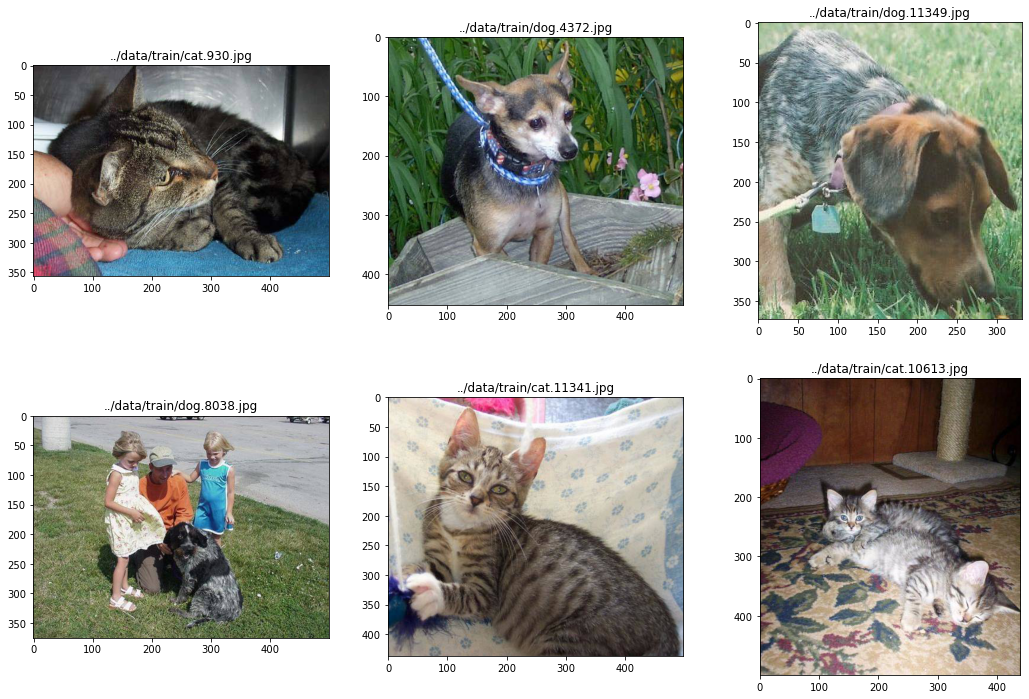

In [9]:
fig, axes = plt.subplots(nrows=2,
                         ncols=3,
                         figsize=(18, 12))
for img_path, ax in zip(train_list, axes.ravel()):
    ax.set_title(img_path)
    ax.imshow(Image.open(img_path))

## Dataset class

See https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class for details.

In [10]:
class DogVsCatDataset(Dataset):
  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
  
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
       
        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
    
        label_category = extract_class_from(img_name)
        label = 1 if label_category == 'dog' else 0
    
        return image, label

## Create dataloaders

See https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#load-data for details.

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [12]:
# Create training and validation datasets
image_datasets = {
    'train': DogVsCatDataset(train_list,
                             transform=data_transforms['train']),
    'val': DogVsCatDataset(val_list,
                           transform=data_transforms['val'])
}

# Create training and validation dataloaders
dataloaders_dict = {x: DataLoader(image_datasets[x],
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize and Reshape the Networks

Regarding tuning VGG, see https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#vgg.



In [13]:
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[6] = nn.Linear(4096, num_classes)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


# Create the Optimizer

See https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#create-the-optimizer for details.

In [14]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


# Run Training and Validation Step

In [15]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/1
----------



train Loss: 0.0546 Acc: 0.9789



val Loss: 0.0241 Acc: 0.9912

Epoch 1/1
----------



train Loss: 0.0290 Acc: 0.9898



val Loss: 0.0211 Acc: 0.9920

Training complete in 5m 53s
Best val Acc: 0.992000


In [26]:
hist
#this is for test and validation dataset

{'accuracy': [0.9789333333333333, 0.98976],
 'val_accuracy': [0.9912000000000001, 0.9920000000000001],
 'loss': [0.05455363015969594, 0.028984978706004718],
 'val_loss': [0.024118620096445085, 0.021059730768203735]}

## Visualize training results

This procedure comes from https://www.tensorflow.org/tutorials/images/classification#visualize_training_results.

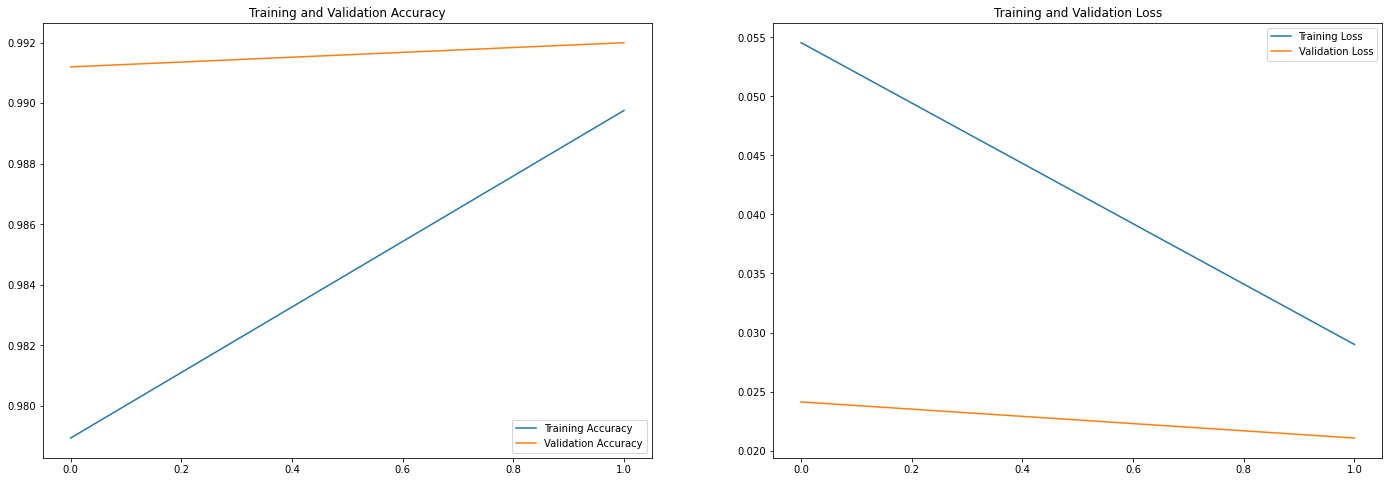

In [16]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
# from sklearn.metrics import precision_score, recall_score, f1_score
# precision = precision_score(y_true, y_pred)
# recall = recall_score(y_true, y_pred)
# f1 = f1_score(y_true, y_pred)

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")

# Predict

In [17]:
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
test_data_transform = data_transforms['val']

ids = []
labels = []

with torch.no_grad():
    for test_path in tqdm(test_list):
        img = Image.open(test_path)
        img = test_data_transform(img)
        img = img.unsqueeze(0)
        img = img.to(device)

        model_ft.eval()
        outputs = model_ft(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        test_id = extract_class_from(test_path)
        ids.append(int(test_id))
        labels.append(preds[0])

## Check how well the prediction went

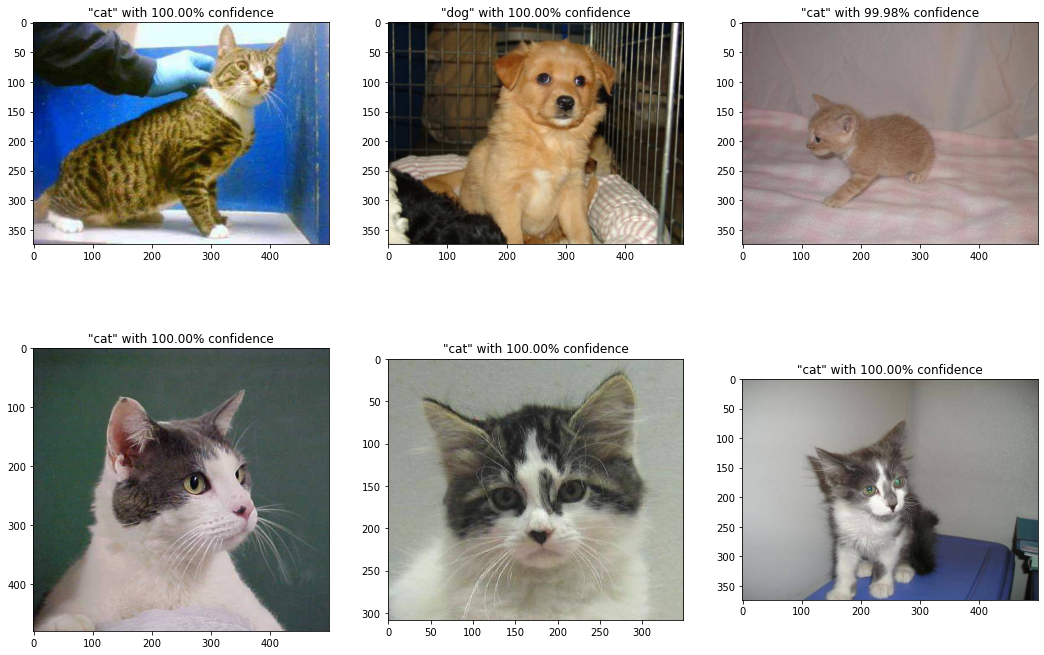

In [18]:
template = '"{}" with {:.2%} confidence'
def pred_result_message(pred):
    if pred > 0.5:
        return template.format('dog', pred)
    else:
        return template.format('cat', 1 - pred)

fig, axes = plt.subplots(nrows=2,
                         ncols=3,
                         figsize=(18, 12))
for img_path, label, ax in zip(test_list, labels, axes.ravel()):
    ax.set_title(pred_result_message(label))
    ax.imshow(Image.open(img_path))

# Generate submittion.csv

In [19]:
output = pd.DataFrame({'id': ids,
                       'label': np.round(labels)})

output.sort_values(by='id', inplace=True)
output.reset_index(drop=True, inplace=True)

output.to_csv('submission.csv', index=False)